In [ ]:
# Based on https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Mount Drive
!unzip /content/drive/MyDrive/TransferLearnImages.zip

!mv ./TransferLearnImages ./train
!mkdir -p ./validation/Football
!mkdir -p ./validation/Racket
!mv ./train/Football/*1* ./validation/Football/
!mv ./train/Racket/*1* ./validation/Racket/

In [88]:
PATH = "/content/"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 149 files belonging to 2 classes.
Found 39 files belonging to 2 classes.


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 0s 103ms/step - loss: 0.6086 - accuracy: 0.5641


In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
5/5 [==============================] - 0s 49ms/step - loss: 0.6504 - accuracy: 0.6376 - val_loss: 0.5804 - val_accuracy: 0.5897
Epoch 2/10
5/5 [==============================] - 0s 46ms/step - loss: 0.6183 - accuracy: 0.7047 - val_loss: 0.5545 - val_accuracy: 0.6410
Epoch 3/10
5/5 [==============================] - 0s 42ms/step - loss: 0.5501 - accuracy: 0.7584 - val_loss: 0.5307 - val_accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 0s 42ms/step - loss: 0.5525 - accuracy: 0.7114 - val_loss: 0.5088 - val_accuracy: 0.7436
Epoch 5/10
5/5 [==============================] - 0s 44ms/step - loss: 0.5314 - accuracy: 0.7584 - val_loss: 0.4883 - val_accuracy: 0.7436
Epoch 6/10
5/5 [==============================] - 0s 44ms/step - loss: 0.5358 - accuracy: 0.7248 - val_loss: 0.4679 - val_accuracy: 0.7436
Epoch 7/10
5/5 [==============================] - 0s 39ms/step - loss: 0.4824 - accuracy: 0.7315 - val_loss: 0.4484 - val_accuracy: 0.7949
Epoch 8/10
5/5 [===========

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
5/5 [==============================] - 1s 183ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 11/20
5/5 [==============================] - 0s 54ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 12/20
5/5 [==============================] - 0s 50ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 13/20
5/5 [==============================] - 0s 51ms/step - loss: 9.8723e-04 - accuracy: 1.0000 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 14/20
5/5 [==============================] - 0s 58ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 15/20
5/5 [==============================] - 0s 55ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 16/20
5/5 [==============================] - 0s 54ms/step - loss: 3.9817e-04 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 17/20

--2020-12-11 22:40:47--  https://image.shutterstock.com/image-photo/soccer-ball-isolated-on-white-260nw-400438939.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 23.36.53.150
Connecting to image.shutterstock.com (image.shutterstock.com)|23.36.53.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9309 (9.1K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   9.09K  --.-KB/s    in 0s      

2020-12-11 22:40:47 (139 MB/s) - ‘image.jpg’ saved [9309/9309]

Football


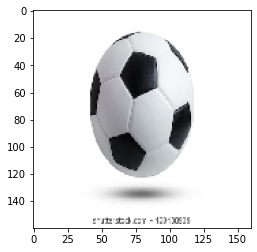

In [87]:
# test model with new image
!wget -O image.jpg https://image.shutterstock.com/image-photo/soccer-ball-isolated-on-white-260nw-400438939.jpg
#!wget -O image.jpg https://www.tennisnuts.com/images/product/full/102334-136_babolat-pure-drive_angle.jpg

# process image for model

img = image.load_img('image.jpg', target_size=IMG_SIZE)
x = image.img_to_array(img)
x = backend.expand_dims(x, axis=0)

# display image
import matplotlib.pyplot as plt
plt.imshow(img)

# run prediction
prediction = model.predict(x)
prediction = tf.nn.sigmoid(prediction)
prediction = tf.where(prediction < 0.5, 0, 1)
print(class_names[prediction.numpy()[0][0]])